In [1]:
# import os
# !pip install torch torchvision feather-format kornia pyarrow Pillow wandb --upgrade 
# !pip install git+https://github.com/fastai/fastai_dev
# os._exit(00)

In [2]:
from fastai2.basics import *
from fastai2.vision.all import *
from fastai2.callback.all import *

In [3]:
# !gdown "https://drive.google.com/uc?id=1ffJr3NrYPqzutcXsYIVNLXzzUaC9RqYM"

In [4]:
# import zipfile
# with zipfile.ZipFile('cat-dataset.zip', 'r') as zip_ref:
#   zip_ref.extractall()

In [5]:
path = Path('data/cat/all');path.ls()

(#19987) [data/cat/all/00001474_006.jpg.cat,data/cat/all/00000343_015.jpg,data/cat/all/00000178_014.jpg.cat,data/cat/all/00000019_024.jpg.cat,data/cat/all/00001387_016.jpg,data/cat/all/00000564_019.jpg.cat,data/cat/all/00000573_028.jpg.cat,data/cat/all/00001085_005.jpg.cat,data/cat/all/00000938_011.jpg,data/cat/all/00001215_023.jpg.cat...]

In [6]:
def get_ip(img:PILImage, pts:array): return TensorPoint(pts, sz=img.size)

In [7]:
def get_points(coords:array):
  coords = np.delete(coords, 0)
  points = []
  temp = []
  for cord in coords:
    temp.append(cord)
    if len(temp) == 2:
      points.append(temp)
      temp = []
  return tensor(points)

In [8]:
def img2txt_name(f): 
  return path/f'{str(f)}.cat'

In [9]:
def get_y(f:Path):
  pts = np.genfromtxt(img2txt_name(f))
  return get_points(pts)

In [10]:
class LabeledPnts(Tuple):
    "Basic type for a list of points in an image"
    def show(self, ctx=None, **kwargs):
        for b,l in zip(self.pnts, self.lbl):
            if l != '#na#':
              ctx = retain_type(b, self.pnts).show(ctx=ctx)
              ctx.annotate(l, b, color=kwargs.get('font_color', 'white'), size=kwargs.get('font_size', 'medium'))

        return ctx

    pnts,lbl = add_props(lambda i,self: self[i])

In [11]:
# def PntLblBlock(vocab=None, add_na=True):
#   return TransformBlock(type_tfms=MultiCategorize(vocab=vocab, add_na=add_na), item_tfms=PntsLabeler)

In [12]:
class PntsLabeler(Transform):
    def setup(self, dl): self.vocab = dl.vocab if dl.vocab else lbls
    def before_call(self): self.pnts,self.lbls = None,None
        
    def decode (self, x, **kwargs): 
        self.pnts,self.lbls = None,None
        return self._call('decodes', x, **kwargs)
    
    def decodes(self, x:TensorMultiCategory): 
        self.lbls = [self.vocab[a] for a in x]
        return x if self.pnts is None else LabeledPnts(self.pnts, self.lbls)
        
    def decodes(self, x:TensorPoint): 
        self.pnts = x
        return self.pnts if self.lbls is None else LabeledPnts(self.pnts, self.lbls)

In [13]:
@MultiCategorize
def decodes(self, x:LabeledPnts): return x

In [14]:
lbls = ['LEye', 'REye', 'Mou', 'LEar-1', 'LEar-2', 'LEar-3', 'REar-1', 'REar-2', 'REar-3' ]

In [15]:
def PntLblBlock(vocab=None, add_na=True):
  return TransformBlock(type_tfms=MultiCategorize(vocab=vocab, add_na=add_na), item_tfms=PntsLabeler)

In [16]:
PointsBlock = TransformBlock(type_tfms=TensorPoint.create, item_tfms=PointScaler)

In [17]:
getters = [noop, lambda o: get_y(o.name)]

In [18]:
# dblock = DataBlock(blocks=(ImageBlock, PointsBlock, PntLblBlock(vocab=lbls)),
#                    get_items=get_image_files,
#                    splitter=RandomSplitter(),
#                    getters=getters,
#                    n_inp=1)
dblock = DataBlock(blocks=(ImageBlock, PointsBlock, PointsBlock),
                   get_items=get_image_files,
                   splitter=RandomSplitter(),
                   getters=getters,
                   n_inp=1)

In [19]:
bs=48 #for ResNet18 460
# bs=96 #for ResNet18 224

In [20]:
dbunch = dblock.databunch(path, path=path, item_tfms=Resize(224), bs=bs,
                batch_tfms=[Normalize.from_stats(*imagenet_stats)])

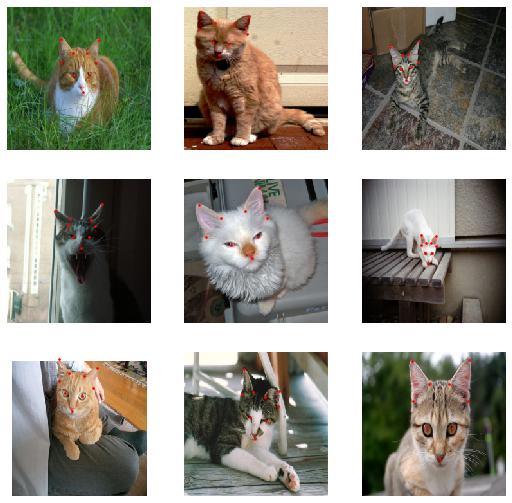

In [21]:
dbunch.show_batch()

In [22]:
class customHead(nn.Module):
  def __init__(self):
    super().__init__()
    self.points = create_head(1024, 18)
    self.classifier = create_head(1024, 100)
  def forward(self, xb):
    pt_out = self.points(xb)
    cls_out = self.classifier(xb)
    return pt_out, cls_out

In [23]:
body = create_body(resnet18)

In [24]:
net = nn.Sequential(body, customHead())

In [25]:
# def myLoss(out, pts, cls):
#   CELF = CrossEntropyLossFlat()
#   loss = 0
#   pt = out[0]
#   for p in range(len(pt)):
#     pred = pt[p].view(-1, 2)
#     loss += F.mse_loss(pred, pts[p])
#   return loss
def myLoss(out, pts):
  CELF = CrossEntropyLossFlat()
  loss = 0
  pt = out[0]
  for p in range(len(pt)):
    pred = pt[p].view(-1, 2)
    loss += F.mse_loss(pred, pts[p])
  return loss

In [26]:
learn = Learner(dbunch, net, loss_func=myLoss, cb_funcs=[EarlyStoppingCallback])

In [27]:
apply_init(learn.model[1], nn.init.kaiming_normal_)

In [28]:
learn.freeze()

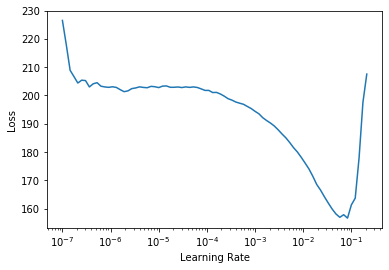

In [29]:
learn.lr_find()

In [30]:
learn.save('i')

In [31]:
learn.load('i');

In [32]:
learn.fit_one_cycle(20, 1e-3)

epoch,train_loss,valid_loss,time
0,153.749878,59.909397,00:44
1,96.823112,15.240852,00:44
2,54.416225,18.127316,00:44
3,27.626877,5.088296,00:43
4,13.798481,6.291782,00:44
5,6.567194,3.825923,00:44
6,3.527579,1.529249,00:44
7,1.823876,1.208061,00:43
8,1.087593,1.269394,00:43
9,0.757957,0.698052,00:43


In [33]:
learn.save('rn18_stage1_224')

In [34]:
learn.load('rn18_stage1_224')

Unfreezing just makes the models worse.  It took 15 epochs to get back to what the frozen training did.

In [35]:
lr = 4e-3

In [36]:
learn.unfreeze()
lrs = slice(lr/400,lr/4)

In [37]:
learn.fit_one_cycle(15, lrs, pct_start=0.8, wd=1e-2)

epoch,train_loss,valid_loss,time
0,0.300935,0.319563,00:44
1,0.325117,0.316422,00:44
2,0.341211,0.329857,00:43
3,0.353157,0.329529,00:44
4,0.385264,0.479337,00:44
5,0.423544,0.422316,00:44
6,0.477100,0.584036,00:44
7,0.499737,0.572832,00:44
8,0.460144,0.541967,00:44
9,0.633788,0.760311,00:43


In [38]:
learn.save('rn18_stage2_224')

In [39]:
learn.load('rn18_stage2_224')

In [40]:
x = dbunch.one_batch()

In [41]:
gtpts = x[1]
# gtcls = x[2]

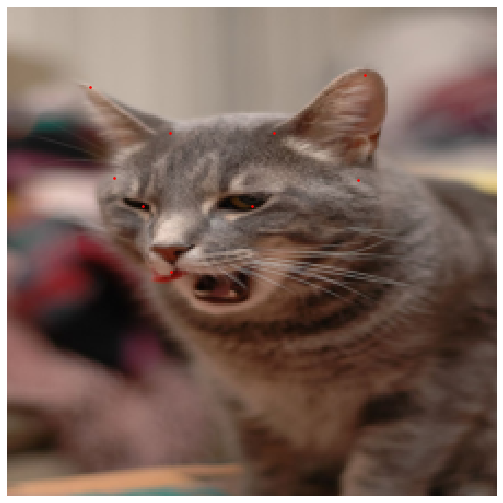

In [42]:
res = learn.model(x[0])
pt = res[0][0].view(-1, 2)
# lbl = res[1][0].view(-1, 10).argmax(-1).unsqueeze(0)
# a, b, c = dbunch.decode_batch((x[0], pt.unsqueeze(0), lbl))[0]
a, b = dbunch.decode_batch((x[0], pt.unsqueeze(0)))[0]
ctx = a.show(figsize=(9,9))
b.show(ctx=ctx)

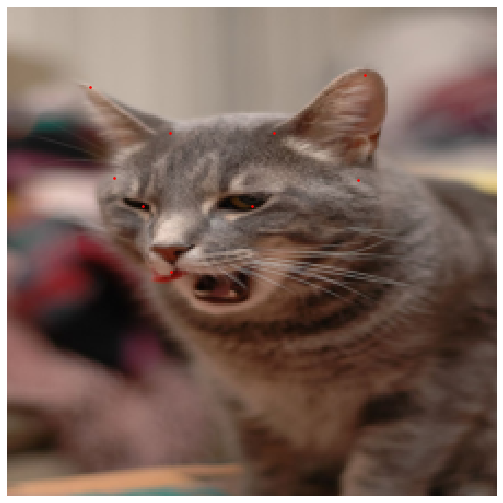

In [43]:
res = learn.model(x[0])
pt = res[0][0].view(-1, 2)
# lbl = res[1][0].view(-1, 10).argmax(-1).unsqueeze(0)
# a, b, c = dbunch.decode_batch((x[0], pt.unsqueeze(0), lbl))[0]
a, b = dbunch.decode_batch((x[0], pt.unsqueeze(0)))[0]
ctx = a.show(figsize=(9,9))
b.show(ctx=ctx)